In [18]:
%matplotlib inline

''' original source for this tutorial
https://betatim.github.io/posts/sklearn-for-TMVA-users/
'''
print ("importing packages for python and ROOT")
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

from root_numpy import root2array, rec2array

print ("importing packages is done")

importing packages for python and ROOT
importing packages is done


In [28]:
print ("importing branches now")

## List the branches names. 

#branch_names = ['PtL1', 'PtL2', 'PtL3', 'PtL4', 'PtJ1', 'PtJ2', 'MJ1', 'MJ2', 'nJet', 'nLep', 'MZ1', 'MZ2', 'PtZ1', 'PtZ2', 'MZZ', 'PtZZ', 'dPhiJJ', 'MJJ', 'EtaJ1xJ2', 'YZ1Star', 'YZ2Star', 'PtZZJJOHtZZJJ', 'Z1Cen', 'Z2Cen']
branch_names = ['massPruned','flavour','nbHadrons','ptPruned','etaPruned','SubJet_csv','z_ratio','trackSipdSig_3','trackSipdSig_2','trackSipdSig_1','trackSipdSig_0','trackSipdSig_1_0','trackSipdSig_0_0','trackSipdSig_1_1','trackSipdSig_0_1','trackSip2dSigAboveCharm_0','trackSip2dSigAboveBottom_0','trackSip2dSigAboveBottom_1','tau0_trackEtaRel_0','tau0_trackEtaRel_1','tau0_trackEtaRel_2','tau1_trackEtaRel_0','tau1_trackEtaRel_1','tau1_trackEtaRel_2','tau_vertexMass_0','tau_vertexEnergyRatio_0','tau_vertexDeltaR_0','tau_flightDistance2dSig_0','tau_vertexMass_1','tau_vertexEnergyRatio_1','tau_flightDistance2dSig_1','jetNTracks','nSV']
"""lepton pT, lepton eta, lepton phi,
missing energy magnitude, missing energy phi,
jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag,
jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag,
jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag,
jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag,
m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb,
m_wwbb.split(",")
"""


branch_names = [c.strip() for c in branch_names]

branch_names = (b.replace(" ", "_") for b in branch_names)

branch_names = list(b.replace("-", "_") for b in branch_names)

#print (branch_names)

## convert ROOT Tree into a 2D array, sciKit works mainly on two d array. 
## 1 d is for variable name and second dimension for the values of those variables. 

## Open the rootfile and read TTree and convert those branches into a 2D record. And then convert this record into
## array. 
signal = root2array("SignalMZp1000_train.root",
                    "outTree",
                    branch_names,
                    selection='ptPruned > 170.0 & ( massPruned < 400) & ( massPruned > 70) '
                   )

# print ("signal")
# print (signal)
signal = rec2array(signal)

backgr = root2array("bkg_QCD500-700_train.root",
                    "outTree",
                    branch_names,
                    selection='ptPruned > 170.0 & ( massPruned < 400) & ( massPruned > 70)'
                   )
backgr = rec2array(backgr)


# for sklearn data is usually organised
# into one 2D array of shape (n_samples x n_features)
# containing all the data and one array of categories
# of length n_samples

# print ('number of branches ='), len(branch_names)
# print ( len(branch_names))
# print (signal.shape) 
# print (backgr.shape) 
## Join signal and background and everything is not contained in single entity. 
X = np.concatenate((signal, backgr))

print ("printing X shape"),(X.shape)
# print (X)
## add one more column, 1 is for signal and 0 is for background. 
y = np.concatenate((np.ones(signal.shape[0]),
                    np.zeros(backgr.shape[0])))
# print (y[0])
# print (signal.shape[0])
# print (np.ones(signal.shape[0]))
# print ((backgr.shape))
# print ("printing Y shape"),(y.shape)
# print (y.shape)


importing branches now
printing X shape


In [29]:
from sklearn.model_selection import train_test_split
print ('size before spliting')
print ('xsize')
print (X.shape)
print ('ysize')
print (y.shape)
X_train,X_test,y_train,y_test = train_test_split (X, y, test_size=0.33, random_state=42)

print ('size after the spliting')
print ('xtrain')
print (X_train.shape)
print ('xtest')
print (X_test.shape)
print ('ytrain')
print (y_train.shape)
print ('ytest')
print (y_test.shape)

size before spliting
xsize
(78295, 33)
ysize
(78295,)
size after the spliting
xtrain
(52457, 33)
xtest
(25838, 33)
ytrain
(52457,)
ytest
(25838,)


In [30]:
print ("start training")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=5)
bdt = AdaBoostClassifier(dt,algorithm='SAMME',n_estimators=800,learning_rate=0.5)
bdt.fit(X_train, y_train)
print ("bdt had done the fitting")

start training
bdt had done the fitting


ypredicted
[1. 1. 0. ... 1. 0. 1.]
             precision    recall  f1-score   support

 background       0.85      0.88      0.87     12333
     signal       0.89      0.86      0.87     13505

avg / total       0.87      0.87      0.87     25838

[ 2.45246467e-01  2.56757635e-04 -6.54134459e-02 ...  1.26363958e-01
 -1.99425198e-01  3.07786337e-01]
Area under the ROC: 0.9367


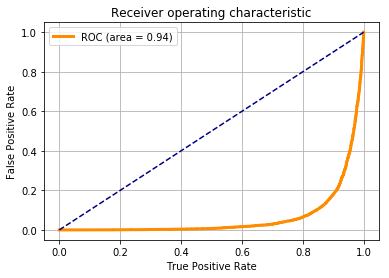

<Figure size 432x288 with 0 Axes>

In [31]:
y_predicted = bdt.predict(X_test)
print ("ypredicted")
print (y_predicted)

print (classification_report(y_test, y_predicted,
                            target_names=["background", "signal"]))

from sklearn.metrics import roc_curve, auc
decisions = bdt.decision_function(X_test)
print (decisions)
print ("Area under the ROC: %.4f" %roc_auc_score(y_test,decisions))

fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(tpr,fpr, color='darkorange', lw=3, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color='navy')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel(r'False Positive Rate')
plt.xlabel(r'True Positive Rate')
plt.title(r'Receiver operating characteristic')
plt.legend(loc="upper left")
plt.grid()
plt.show()
plt.savefig('roc')

/Users/dekumar/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


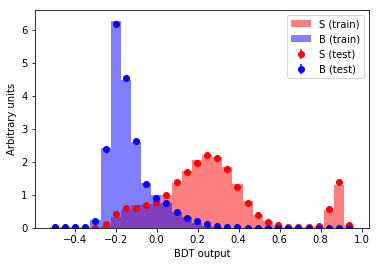

In [32]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)

In [34]:
from root_numpy import array2root

y_predicted = bdt.decision_function(X)
y_predicted.dtype = [('y', np.float64)]

array2root(y_predicted, "prediction.root", "BDToutput")
print ("rootfile written")

rootfile written


In [41]:
import pandas.core.common as com
from pandas.core.index import Index

from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

# Create a pandas DataFrame for our data
# this provides many convenience functions
# for exploring your dataset
# need to reshape y so it is a 2D array with one column
df = pd.DataFrame(np.hstack((X, y.reshape(y.shape[0], -1))),
                  columns=branch_names+['y'])

#print ("df")
#print (df)
print ((branch_names+['y']))
#print ("reshaping");(y.reshape(y.shape[0], -1))
#print ((y.shape[0], -1))
#print (y.reshape(y.shape[0], -1))
#print (X, y.reshape(y.shape[0], -1))

def signal_background(data1, data2, column=None, grid=True,
                      xlabelsize=None, xrot=None, ylabelsize=None,
                      yrot=None, ax=None, sharex=False,
                      sharey=False, figsize=None,
                      layout=None, bins=10, **kwds):
    """Draw histogram of the DataFrame's series comparing the distribution
    in `data1` to `data2`.
    
    data1: DataFrame
    data2: DataFrame
    column: string or sequence
        If passed, will be used to limit data to a subset of columns
    grid : boolean, default True
        Whether to show axis grid lines
    xlabelsize : int, default None
        If specified changes the x-axis label size
    xrot : float, default None
        rotation of x axis labels
    ylabelsize : int, default None
        If specified changes the y-axis label size
    yrot : float, default None
        rotation of y axis labels
    ax : matplotlib axes object, default None
    sharex : bool, if True, the X axis will be shared amongst all subplots.
    sharey : bool, if True, the Y axis will be shared amongst all subplots.
    figsize : tuple
        The size of the figure to create in inches by default
    layout: (optional) a tuple (rows, columns) for the layout of the histograms
    bins: integer, default 10
        Number of histogram bins to be used
    kwds : other plotting keyword arguments
        To be passed to hist function
    """
        
    if 'alpha' not in kwds:
        kwds['alpha'] = 0.5

    if column is not None:
        if not isinstance(column, (list, np.ndarray, Index)):
            column = [column]
        data1 = data1[column]
        data2 = data2[column]
        
    data1 = data1._get_numeric_data()
    data2 = data2._get_numeric_data()
    naxes = len(data1.columns)

    fig, axes = plotting._subplots(naxes=naxes, ax=ax, squeeze=False,
                                   sharex=sharex,
                                   sharey=sharey,
                                   figsize=figsize,
                                   layout=layout)
    _axes = plotting._flatten(axes)

    for i, col in enumerate(com._try_sort(data1.columns)):
        ax = _axes[i]
        low = min(data1[col].min(), data2[col].min())
        high = max(data1[col].max(), data2[col].max())
        ax.hist(data1[col].dropna().values,
                bins=bins, range=(low,high), **kwds)
        ax.hist(data2[col].dropna().values,
                bins=bins, range=(low,high), **kwds)
        ax.set_title(col)
        ax.grid(grid)

    plotting._set_ticks_props(axes, xlabelsize=xlabelsize, xrot=xrot,
                              ylabelsize=ylabelsize, yrot=yrot)
    fig.subplots_adjust(wspace=0.3, hspace=0.7)

    return axes

# Plot signal and background distributions for some
# variables
# The first two arguments select what is "signal"
# and what is "background". This means you can
# use it for more general comparisons of two
# subsets as well.
#############################  signal_background(df[df.y<0.5], df[df.y>0.5] )


['massPruned', 'flavour', 'nbHadrons', 'ptPruned', 'etaPruned', 'SubJet_csv', 'z_ratio', 'trackSipdSig_3', 'trackSipdSig_2', 'trackSipdSig_1', 'trackSipdSig_0', 'trackSipdSig_1_0', 'trackSipdSig_0_0', 'trackSipdSig_1_1', 'trackSipdSig_0_1', 'trackSip2dSigAboveCharm_0', 'trackSip2dSigAboveBottom_0', 'trackSip2dSigAboveBottom_1', 'tau0_trackEtaRel_0', 'tau0_trackEtaRel_1', 'tau0_trackEtaRel_2', 'tau1_trackEtaRel_0', 'tau1_trackEtaRel_1', 'tau1_trackEtaRel_2', 'tau_vertexMass_0', 'tau_vertexEnergyRatio_0', 'tau_vertexDeltaR_0', 'tau_flightDistance2dSig_0', 'tau_vertexMass_1', 'tau_vertexEnergyRatio_1', 'tau_flightDistance2dSig_1', 'jetNTracks', 'nSV', 'y']


In [40]:
import matplotlib.pyplot as plt
def make2dplot():
    df.loc[random.sample(df.index, 1000)].plot(kind='scatter',  x='lepton_pT', y='jet_3_pt',    c='y', cmap='autumn')
    plt.show()
    bg = df.y < 0.5
    sig = df.y > 0.5


TypeError: Population must be a sequence or set.  For dicts, use list(d).

In [37]:
def printCorrelation():
    #this works but takes some time
    #a=df[bg].corr()
    print (df)
    print (type(df[bg].corr()))
    print (' ---------------------')
    print (df[sig].corr())


In [39]:
signal_background(massPruned, massPruned )

NameError: name 'massPruned' is not defined